In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import json
import pandas as pd
import os

In [4]:
ROOT_DIR = '../../'
import sys
sys.path.insert(0, ROOT_DIR)

import eval_utils
from shapeworld import COLORS, SHAPES

In [5]:
TRAIN_DATASET = 'rf-typicality-unishape'
EVAL_DATASET = 'rf-typicality-unishape'

In [6]:
RESULTS_DIR = os.path.join(ROOT_DIR, 'eval_results', TRAIN_DATASET, 'l0-semantics') \
                + ('' if TRAIN_DATASET == EVAL_DATASET else f'_eval={EVAL_DATASET}')

# Load raw outputs 

In [7]:
num_listeners = len(os.listdir(RESULTS_DIR))
outputs_per_listener = [None] * num_listeners
for rel_fp in sorted(os.listdir(RESULTS_DIR)):
    listener_idx = int(rel_fp.split('.')[0].split('_')[-1])
    with open(os.path.join(RESULTS_DIR, rel_fp), 'r') as f:
        outputs_per_listener[listener_idx] = json.load(f)

In [8]:
# visualize outputs
outputs_per_listener[0][:2]

[{'color': 'green',
  'shape': 'square',
  'utterances': [{'utterance': 'green square',
    'label': 1.0,
    'sem': 0.9999964237213135},
   {'utterance': 'green shape', 'label': 1.0, 'sem': 0.9998862743377686},
   {'utterance': 'square', 'label': 1.0, 'sem': 0.9999959468841553},
   {'utterance': 'blue square', 'label': 0.0, 'sem': 0.010013636201620102},
   {'utterance': 'blue shape', 'label': 0.0, 'sem': 2.6550544589554192e-06},
   {'utterance': 'green rectangle', 'label': 0.0, 'sem': 0.9461395144462585},
   {'utterance': 'rectangle', 'label': 0.0, 'sem': 0.18388426303863525}]},
 {'color': 'red',
  'shape': 'circle',
  'utterances': [{'utterance': 'red circle',
    'label': 1.0,
    'sem': 0.9995610117912292},
   {'utterance': 'red shape', 'label': 1.0, 'sem': 0.9999990463256836},
   {'utterance': 'circle', 'label': 1.0, 'sem': 0.999927282333374},
   {'utterance': 'yellow circle', 'label': 0.0, 'sem': 0.00037682641413994133},
   {'utterance': 'blue shape', 'label': 0.0, 'sem': 0.00261

# Intralistener variation

In [9]:
import itertools
import matplotlib.pyplot as plt
import math

In [10]:
combo_utterances = {(color, shape): f'{color} {shape}' for color, shape in itertools.product(COLORS, SHAPES)}
shape_utterances = {shape: shape for shape in SHAPES}
color_utterances = {color: f'{color} shape' for color in COLORS}
utterances = {**combo_utterances, **shape_utterances, **color_utterances}

In [11]:
def process_raw_outputs(referent_colors=COLORS,
                        referent_shapes=SHAPES,
                        utterances_of_interest=utterances, 
                        label_of_interest=None,
                       ):
    if type(label_of_interest) is str and label_of_interest not in {'pos', 'neg'}:
        raise ValueError('`label_of_interest` must be either `pos` or `neg`.')
    semantics_per_listener = []
    for output in outputs_per_listener:
        filtered_output = [utterance_record for example in output \
                           if example['color'] in referent_colors and example['shape'] in referent_shapes \
                           for utterance_record in example['utterances']]
        curr_listener_sem = {'pos': {}, 'neg': {}} if label_of_interest is None else {label_of_interest: {}}
        for label in curr_listener_sem:
            for utterance, raw_utterance in utterances.items():
                if utterance not in utterances_of_interest: continue
                filter_func = lambda x: x['utterance'] == raw_utterance and x['label'] == int(label == 'pos')
                sem = np.asarray([example['sem'] for example in filter(filter_func, filtered_output)])
                curr_listener_sem[label][utterance] = {'mean': sem.mean(), 'std': sem.std(), 'num_examples': len(sem)}
        semantics_per_listener.append(curr_listener_sem)
    return semantics_per_listener

In [12]:
semantics_per_listener = process_raw_outputs()

In [13]:
def plot_semantics_per_listener(sem_per_listener, utterance_type, plot_pos: bool):
    '''
    utterance_type: any of `combo_utterances`, `color_utterances`, `shape_utterances`
    plot_pos: select positively labeled utterance-image pairs if True, 
                else select negatively labeled utterance-image pairs
    '''
    sem_per_listener_of_utterance_type = [{key: val for key,val in listener['pos' if plot_pos else 'neg'].items() 
                                          if key in utterance_type} for listener in sem_per_listener]
    sem_dfs = [pd.DataFrame(sem).T for sem in sem_per_listener_of_utterance_type]
    
    num_listeners = len(sem_per_listener)
    num_cols = 3
    num_rows = math.ceil(num_listeners / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(10 * num_rows, 10 * num_cols))
    
    fontsize = 18
    ymin, ymax = 0, 1.19 
    for i, df in enumerate(sem_dfs):
        std_dev = df['std']
        row_idx = i // num_cols
        col_idx = i%num_cols
        ax = df['mean'].plot.bar(yerr=std_dev, 
                                     rot=0,
                                     # figsize=(8,6),
                                     ylim=(ymin,ymax),
                                     ax=axs[row_idx, col_idx],
                                     fontsize=fontsize,
                                )
        for label, p in zip(ax.get_xticklabels(), ax.patches):
            ax.annotate(format(p.get_height(), '.3f'),
                    (p.get_x() + p.get_width() / 2., p.get_height() + std_dev[label.get_text()]),
                    ha='center',
                    va='center',
                    xytext=(0, 9),
                    fontsize=fontsize,
                    textcoords='offset points')
        ax.set_title(f'Listener {i}', fontsize=fontsize + 4)

    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axis
    plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
    plt.xlabel(f"Mean of $L_0($modifier, referent$)$ when modifier {'correctly' if plot_pos else 'incorrectly'} describes the referent",
                  fontsize=fontsize + 10)
    plt.show(fig)
    

## Color 

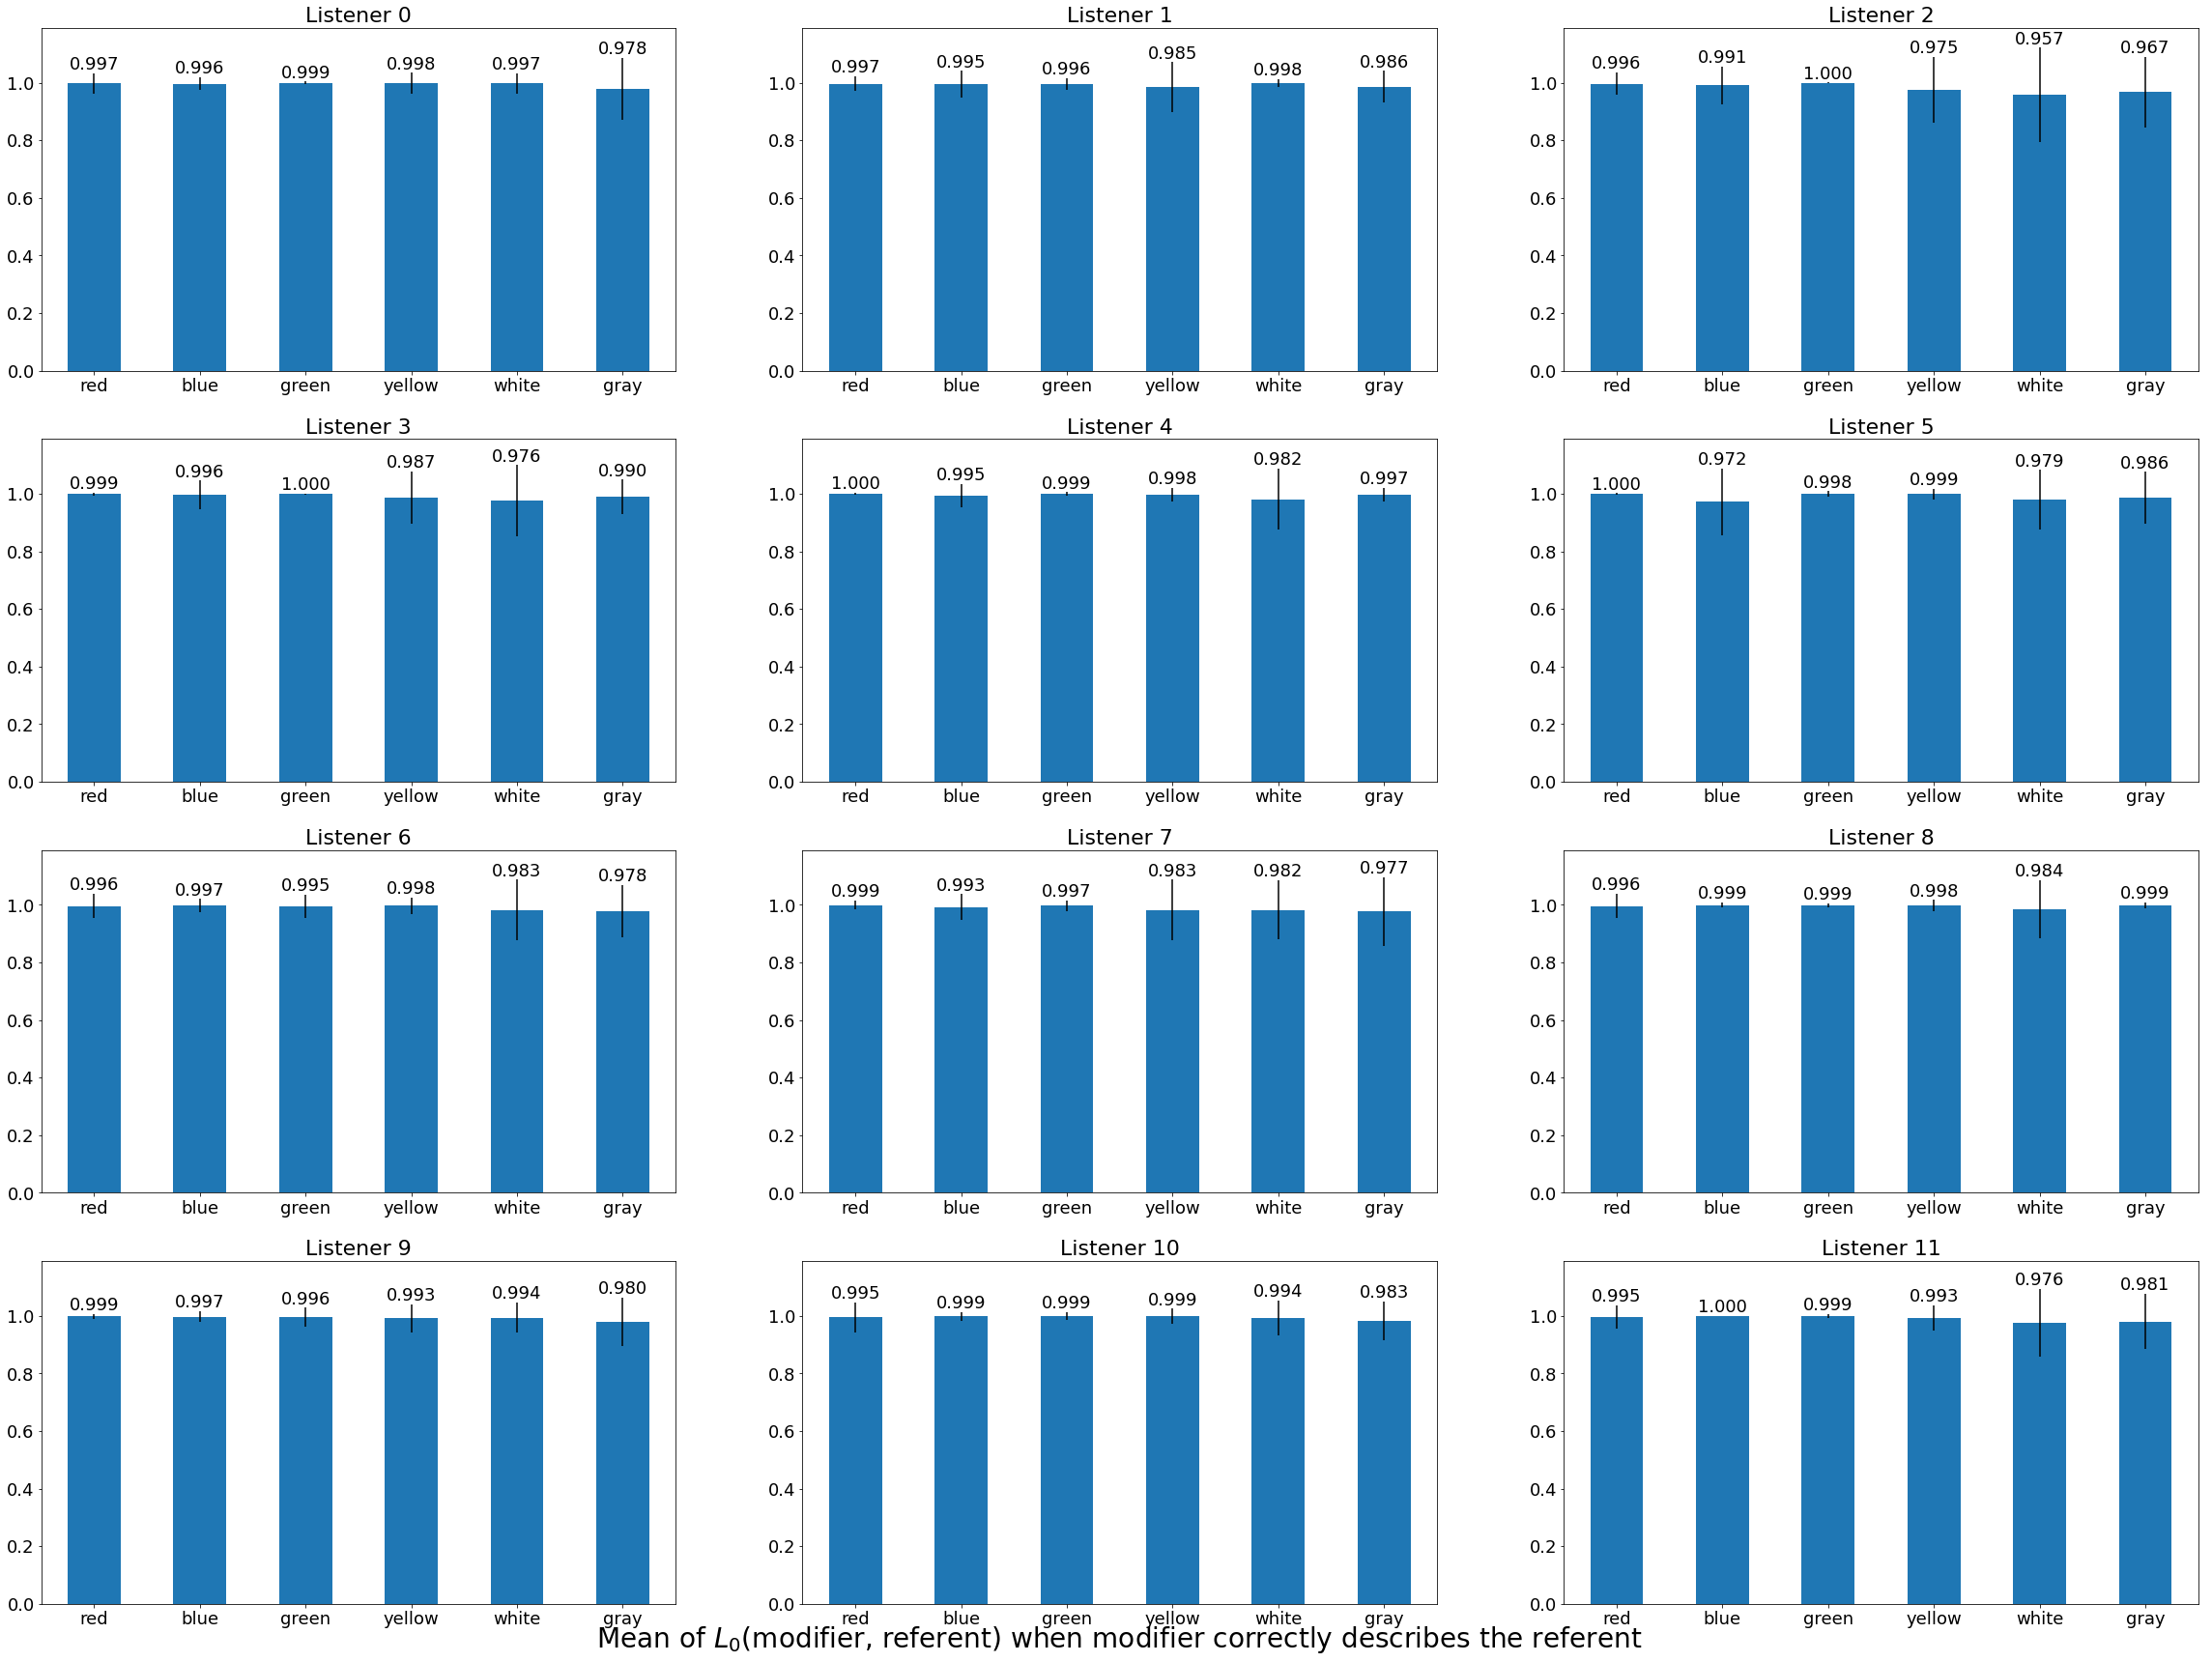

In [14]:
# recall
plot_semantics_per_listener(semantics_per_listener, color_utterances, plot_pos=True)

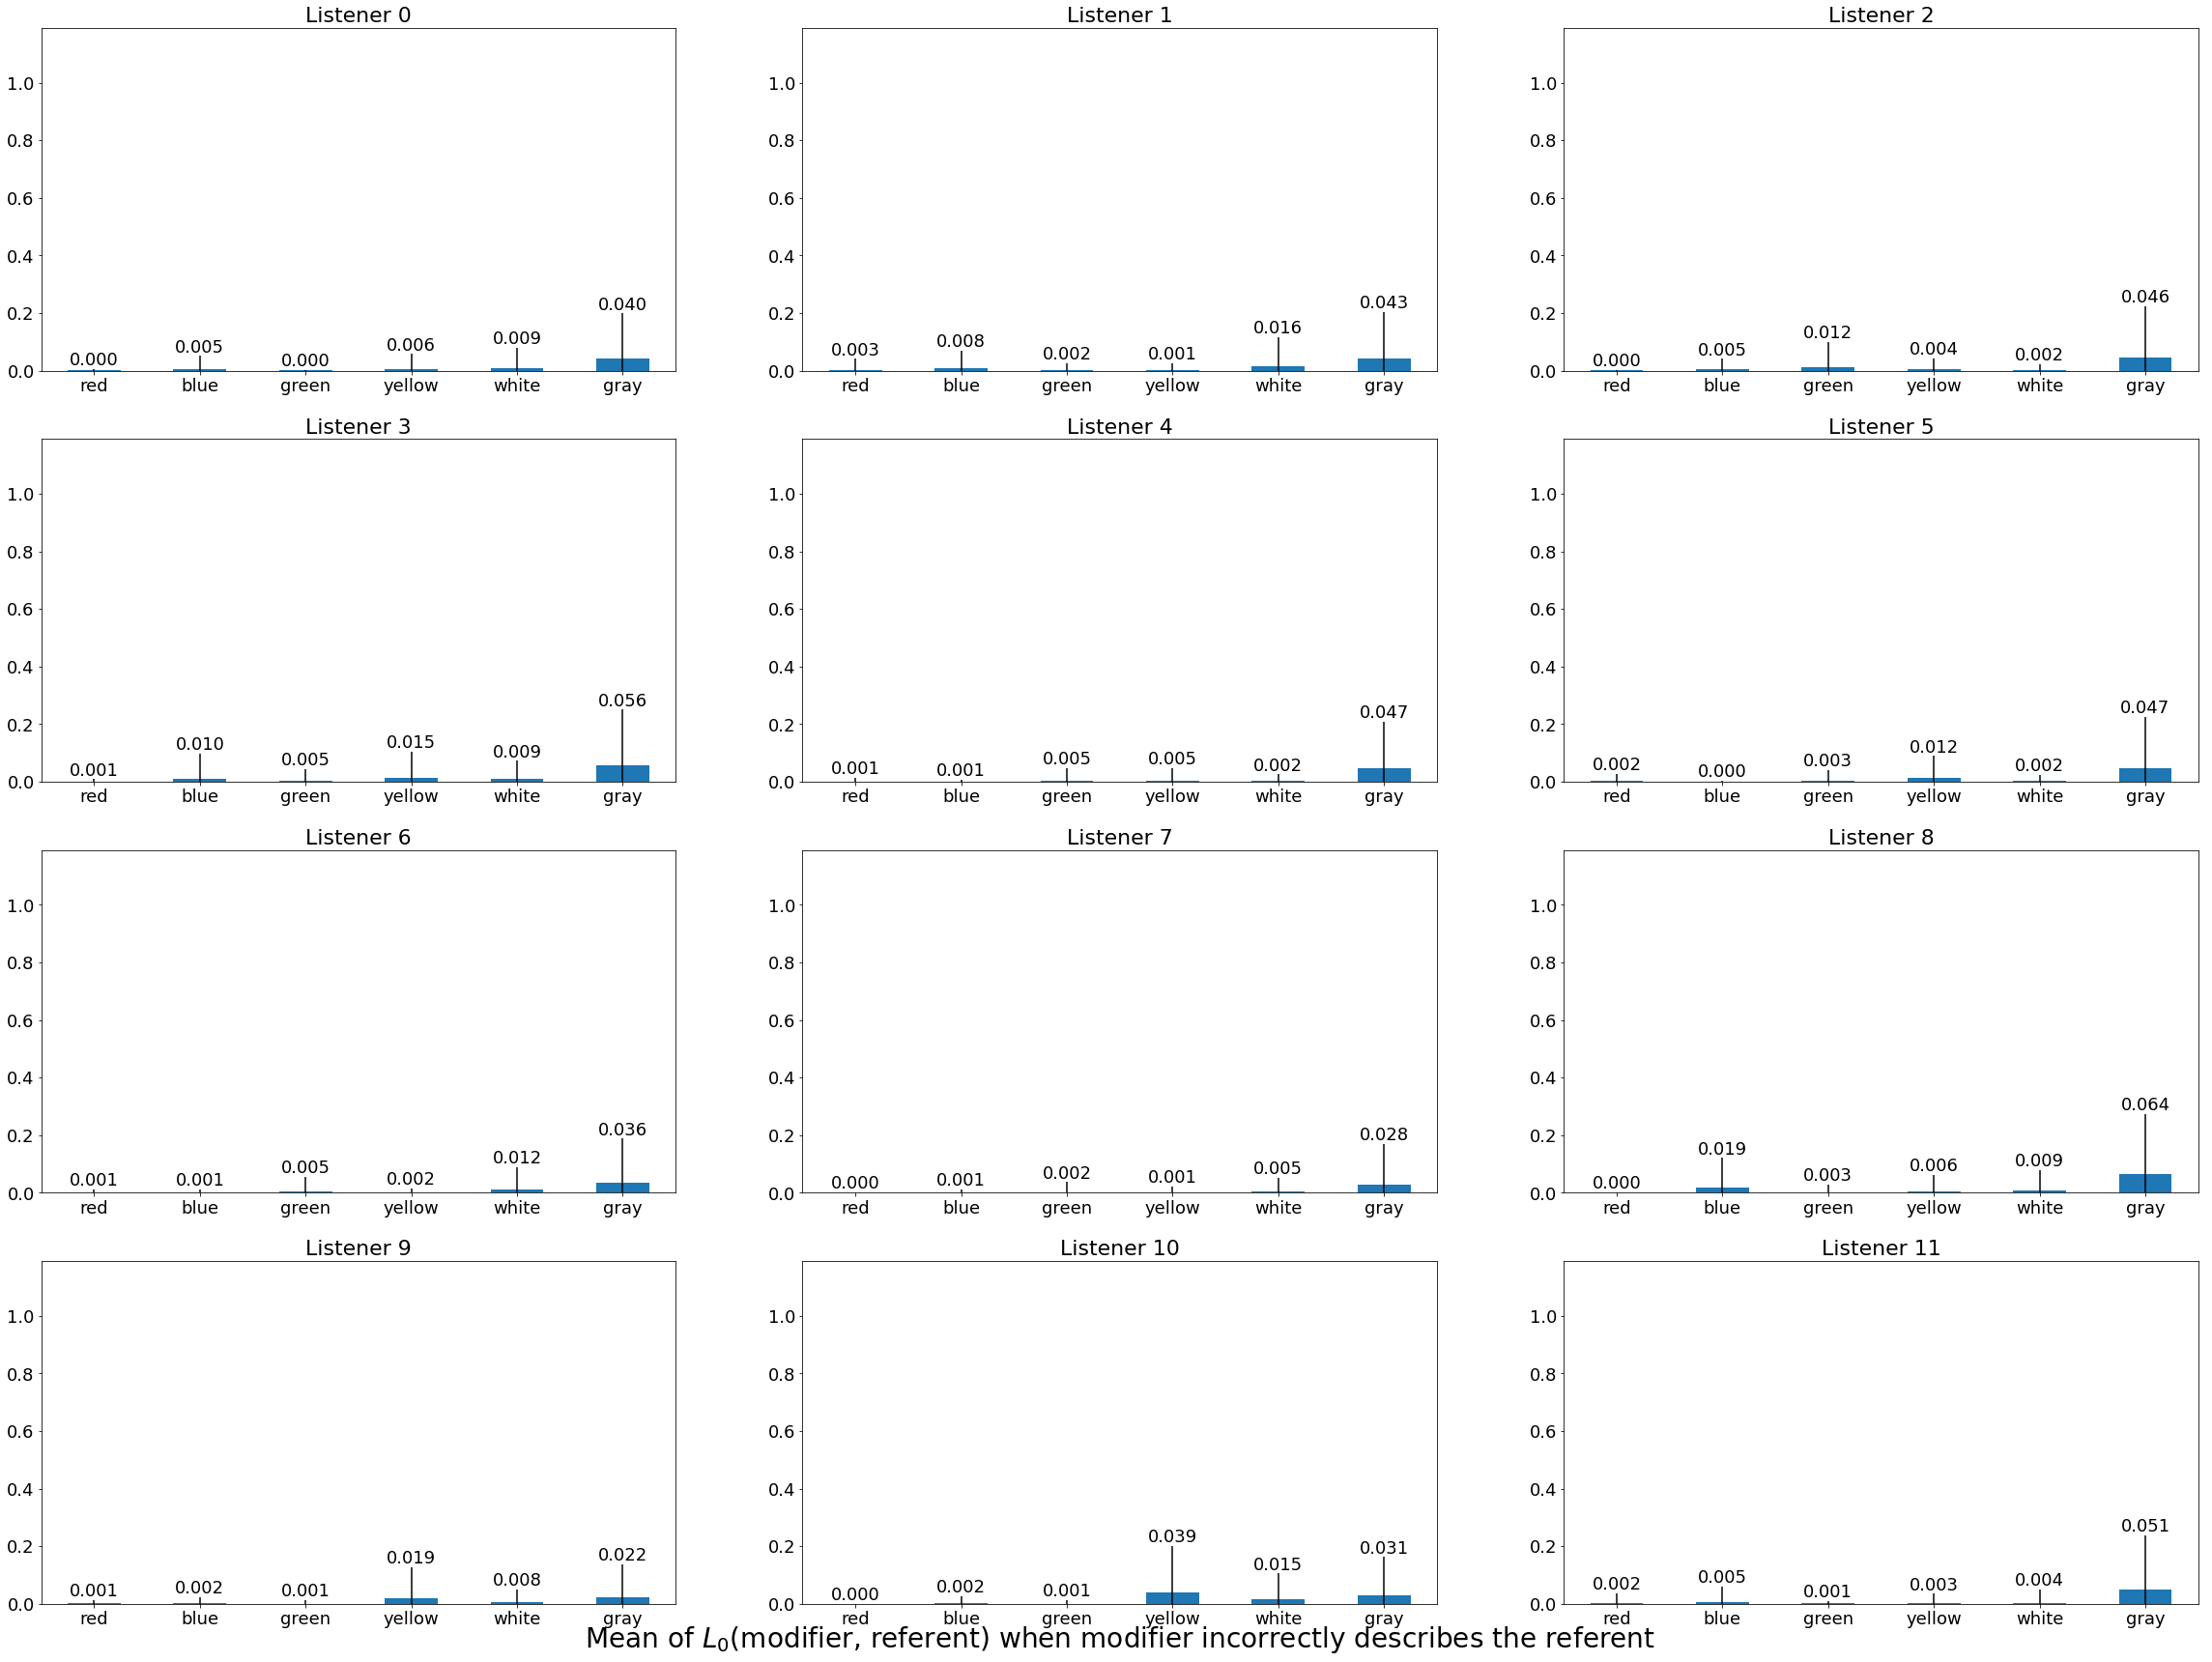

In [15]:
# precision
plot_semantics_per_listener(semantics_per_listener, color_utterances, plot_pos=False)

## Shape

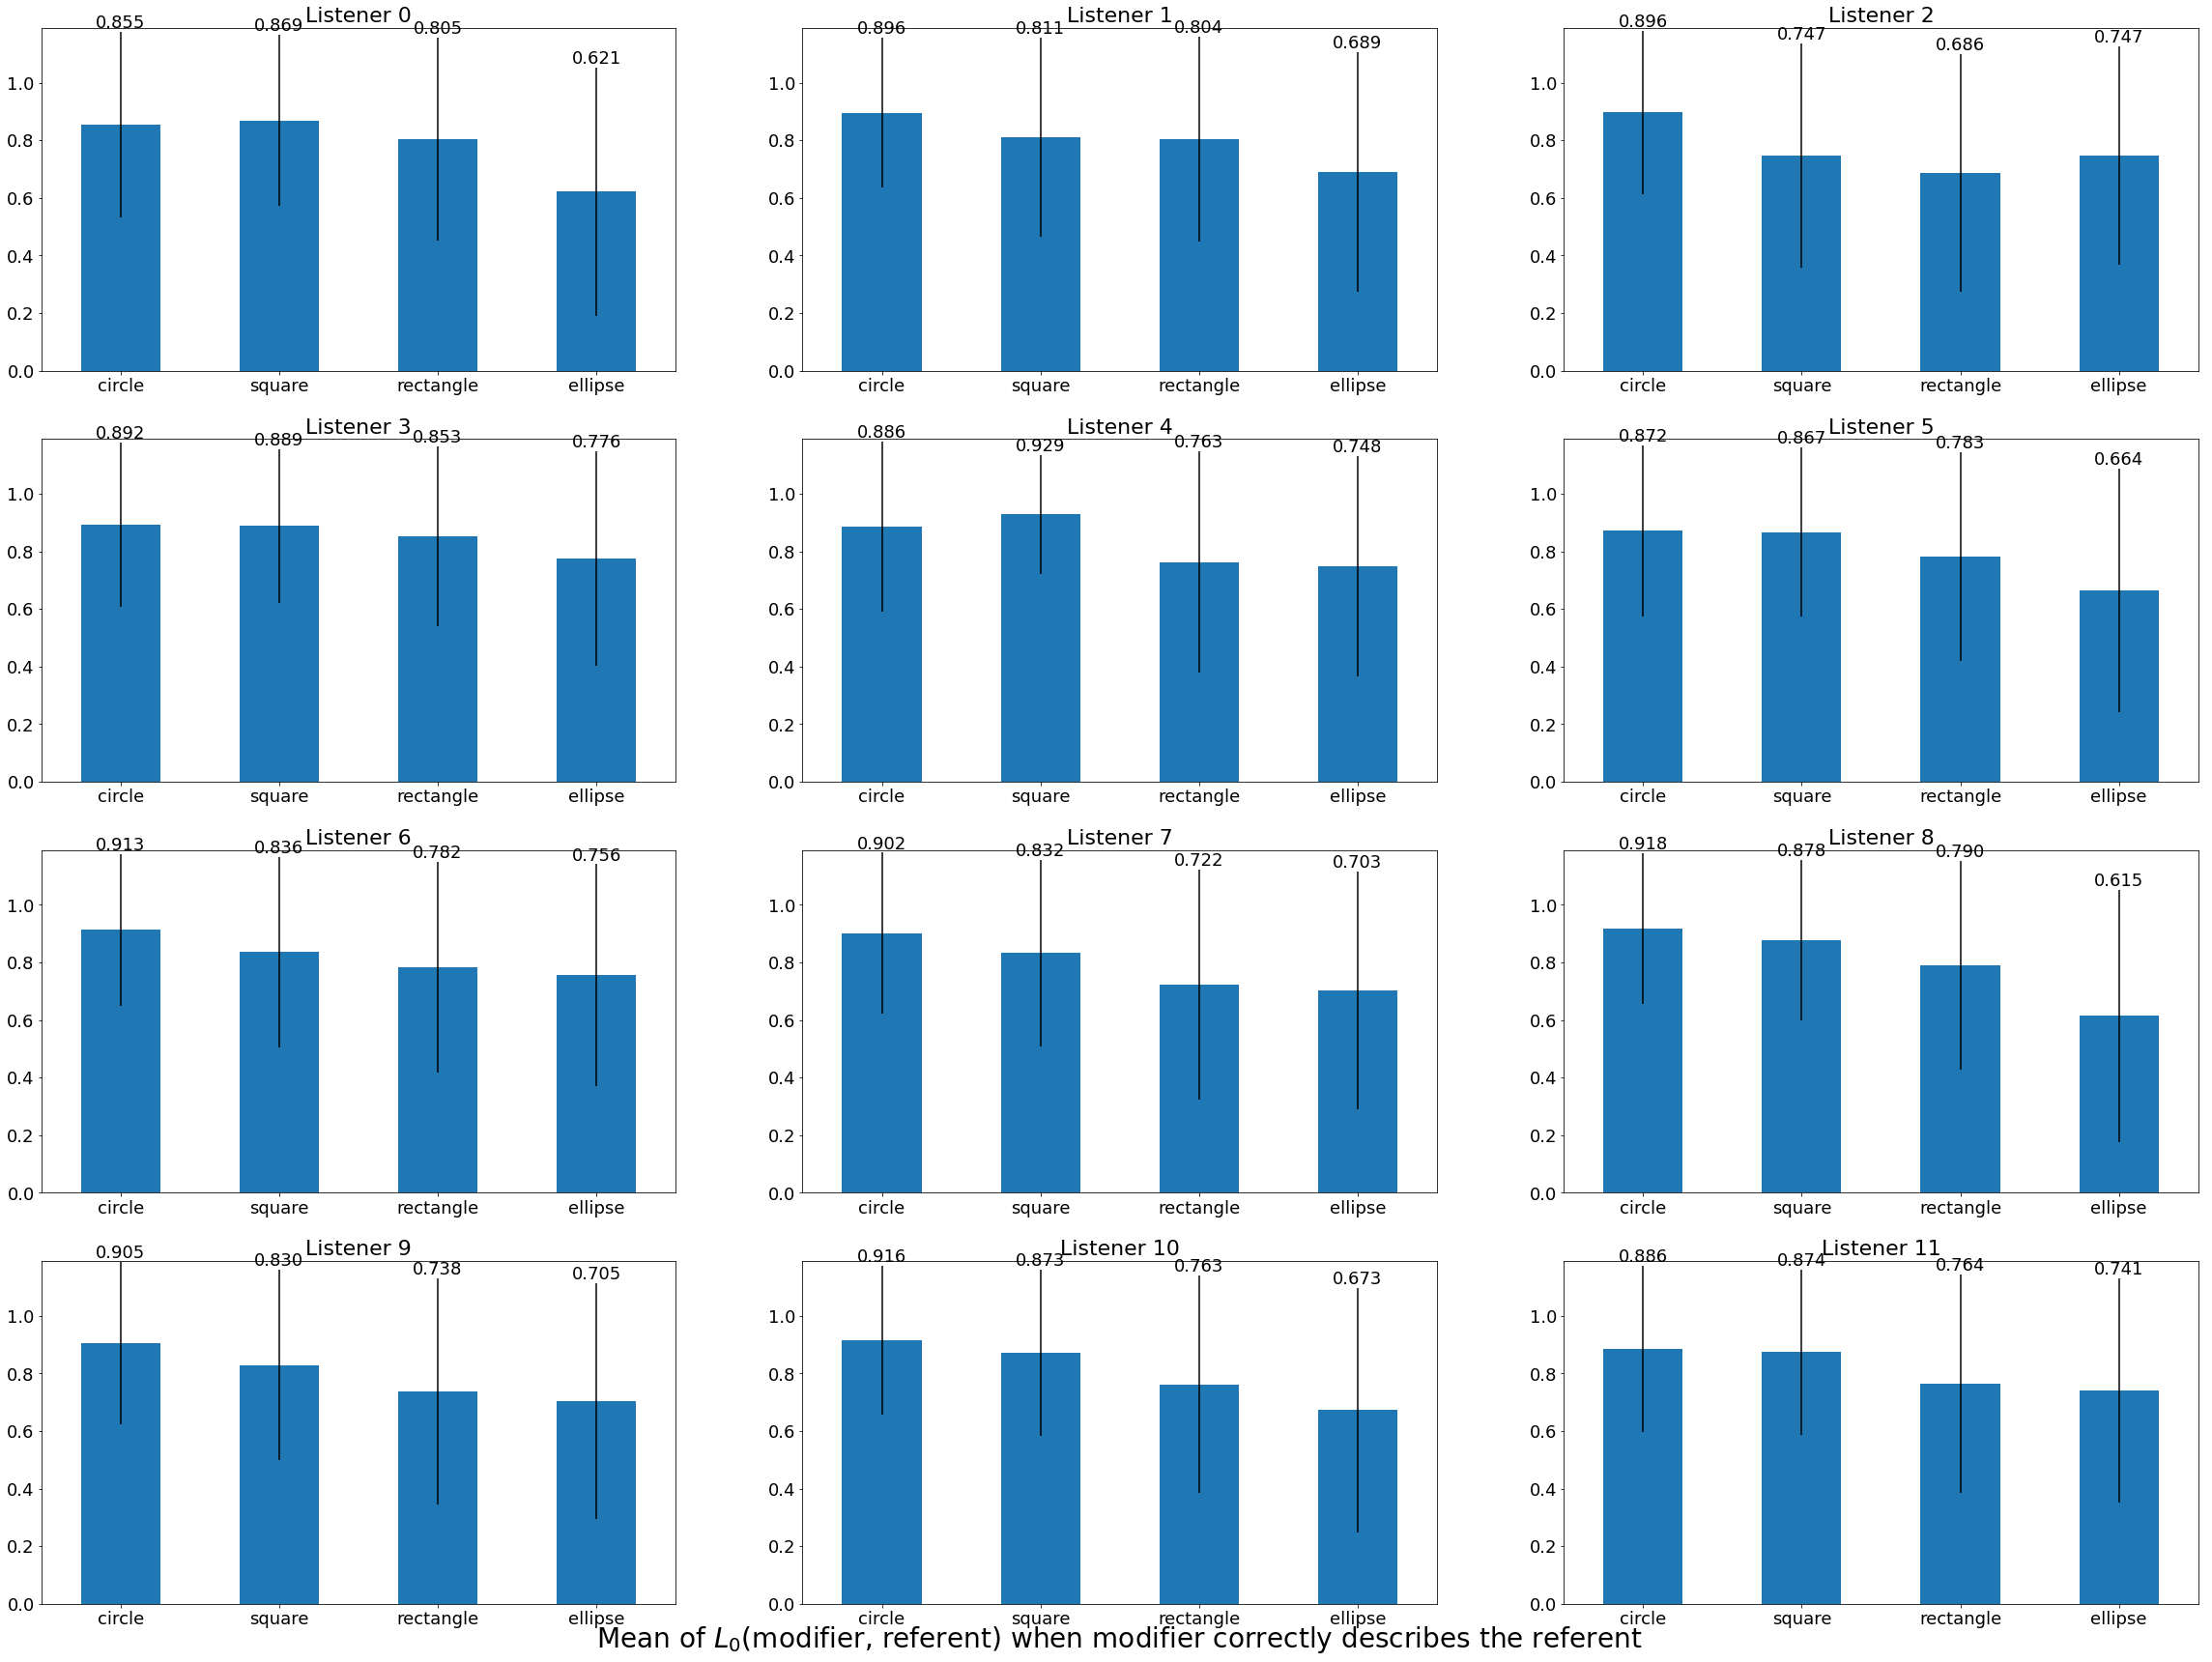

In [16]:
## recall
plot_semantics_per_listener(semantics_per_listener, shape_utterances, plot_pos=True)

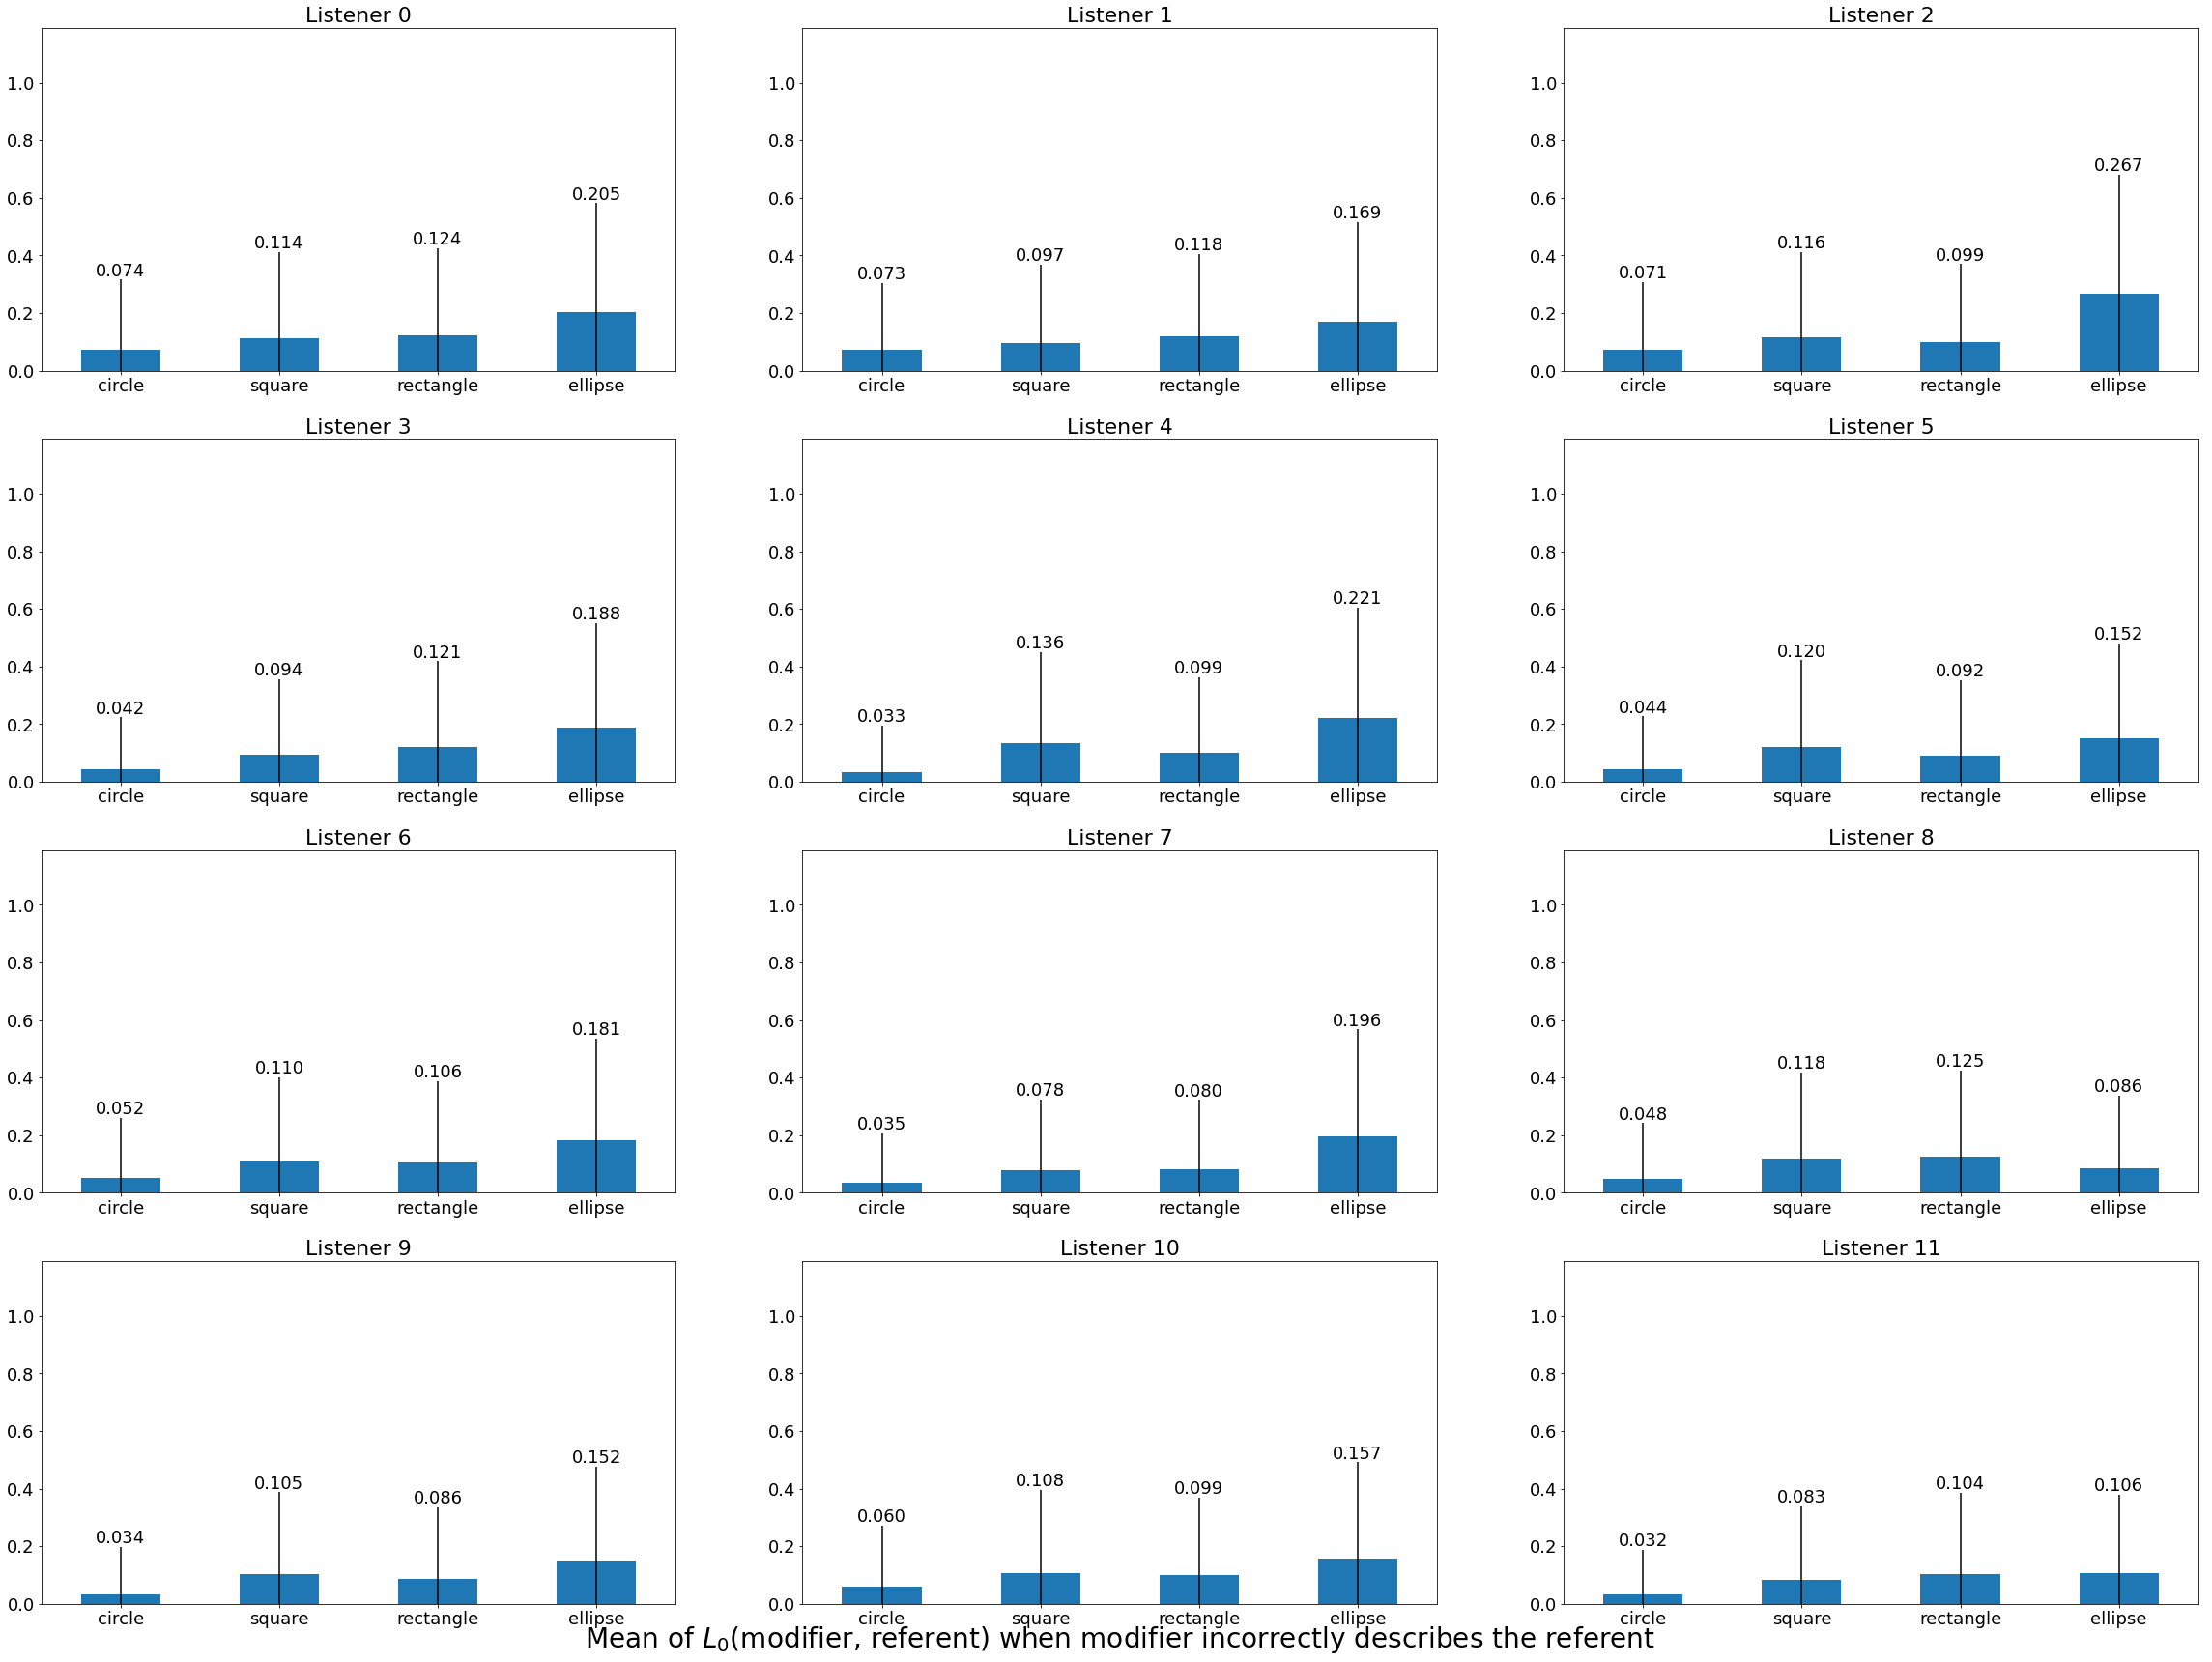

In [17]:
# precision
plot_semantics_per_listener(semantics_per_listener, shape_utterances, plot_pos=False)

# Interlistener variation

In [20]:
import random

In [21]:
def compile_aggregate_semantics_from_individuals(sem_per_listener):
    aggregate_semantics = {}
    labels = list(sem_per_listener[0].keys())
    utterances_of_interest = sem_per_listener[0][random.choice(labels)].keys()
    for label in labels:
        semantics_for_curr_label = {}
        for config in utterances_of_interest:
            semantics_of_all_listeners = [curr_listener_sem[label][config] for curr_listener_sem in sem_per_listener]
            mean_semantics_per_listener = np.asarray([sem['mean'] for sem in semantics_of_all_listeners])
            std_semantics_per_listener = np.asarray([sem['std'] for sem in semantics_of_all_listeners])
            num_examples_per_listener = np.asarray([sem['num_examples'] for sem in semantics_of_all_listeners])
            semantics_for_curr_label[config] = {'mean': mean_semantics_per_listener.mean(), 
                                                'std': mean_semantics_per_listener.std(),
                                                'num_examples': num_examples_per_listener.mean()}
        aggregate_semantics[label] = semantics_for_curr_label
    return aggregate_semantics

In [22]:
aggregate_semantics = compile_aggregate_semantics_from_individuals(semantics_per_listener)

In [23]:
def plot_aggregate_semantics(agg_sem, utterance_type, plot_pos: bool):
    '''
    utterance_type: any of `combo_utterances`, `color_utterances`, `shape_utterances`
    plot_pos: select positively labeled utterance-image pairs if True, 
                else select negatively labeled utterance-image pairs
    '''
    agg_sem_of_utterance_type = {key: val for key,val in agg_sem['pos' if plot_pos else 'neg'].items() 
                                          if key in utterance_type}
    agg_sem_df = pd.DataFrame(agg_sem_of_utterance_type).T
    std_dev = agg_sem_df['std']
    
    fontsize = 14
    ymin, ymax = 0, 1.19 
    ax = agg_sem_df['mean'].plot.bar(yerr=std_dev, 
                                 rot=0,
                                 figsize=(8,6),
                                 ylim=(ymin,ymax),
                                 fontsize=fontsize,
                            )
    for label, p in zip(ax.get_xticklabels(), ax.patches):
        ax.annotate(format(p.get_height(), '.3f'),
                (p.get_x() + p.get_width() / 2., p.get_height() + std_dev[label.get_text()]),
                ha='center',
                va='center',
                xytext=(0, 9),
                fontsize=fontsize,
                textcoords='offset points')
    ax.set_ylabel(f"Mean of $L_0($modifier, referent$)$\n when modifier {'correctly' if plot_pos else 'incorrectly'} describes the referent",
                  fontsize=fontsize)

    plt.show(ax)
    

## Color 

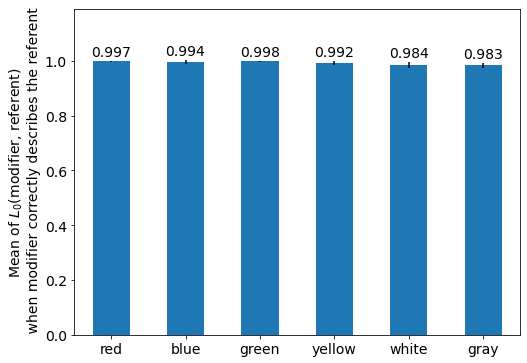

In [24]:
plot_aggregate_semantics(aggregate_semantics, color_utterances, plot_pos=True)

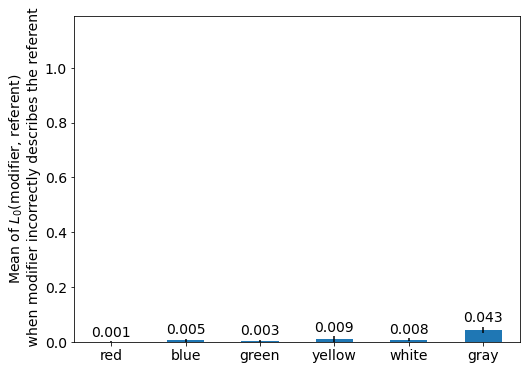

In [25]:
plot_aggregate_semantics(aggregate_semantics, color_utterances, plot_pos=False)

## Shape 

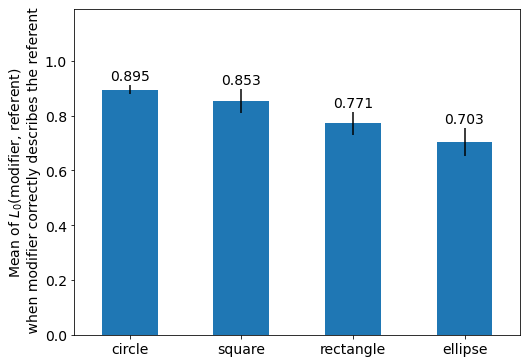

In [26]:
plot_aggregate_semantics(aggregate_semantics, shape_utterances, plot_pos=True)

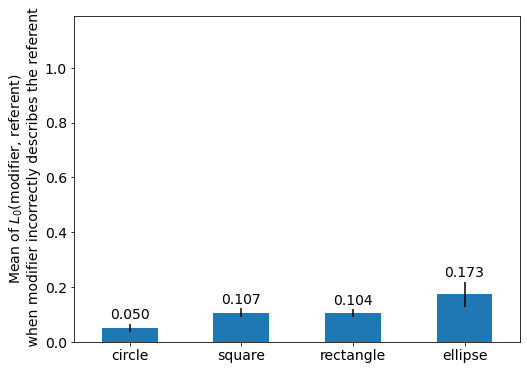

In [27]:
plot_aggregate_semantics(aggregate_semantics, shape_utterances, plot_pos=False)

## Contrast with `rf-uniform`: `circle` 

In [28]:
circle_sem = {} 
for color in COLORS:
    circle_sem[color] = process_raw_outputs(referent_colors=[color], 
                                                 referent_shapes=['circle'], 
                                                 utterances_of_interest=['circle', color, (color, 'circle')],
                                                 label_of_interest='pos'
                                                )


In [29]:
import pprint
pp = pprint.PrettyPrinter(indent=2)

In [30]:
for color, sem in circle_sem.items():
    pp.pprint(compile_aggregate_semantics_from_individuals(sem))

{ 'pos': { 'circle': { 'mean': 0.9628198711738656,
                       'num_examples': 1133.0,
                       'std': 0.019732876227810305},
           'red': { 'mean': 0.9994560890984768,
                    'num_examples': 1133.0,
                    'std': 0.0006313865937403578},
           ('red', 'circle'): { 'mean': 0.9749477398752195,
                                'num_examples': 1133.0,
                                'std': 0.01582007993283221}}}
{ 'pos': { 'blue': { 'mean': 0.9909825106748403,
                     'num_examples': 26.0,
                     'std': 0.01355049208896678},
           'circle': { 'mean': 0.20652869219226044,
                       'num_examples': 26.0,
                       'std': 0.10464536171683238},
           ('blue', 'circle'): { 'mean': 0.6098058172061531,
                                 'num_examples': 26.0,
                                 'std': 0.1396869465464507}}}
{ 'pos': { 'circle': { 'mean': 0.1695755591700595,
        